# Predicting Brand Exposure
## 01_Analysis and Visualization
* Prepare and structure data for analysis.
* This step is intended for data exploration to see if we can find patterns and insights

In [8]:
#load data
import pandas as pd
import json

excel_file_path = '../data_archives/df.xlsx'
json_file_path = '../data_archives/local_venue_poptimes.json'

df = pd.read_excel(excel_file_path)
json_data = open(json_file_path).read()
pop_times = json.loads(json_data)

In [9]:
records_lat = []
records_lng = []
records_count = []
records_hour = []
for day in range(6):
    for hour in range(24):
        for venue in range(len(pop_times)):
            venue_lat = pop_times[venue]['coordinates']['lat']
            venue_lng = pop_times[venue]['coordinates']['lng']
            count = pop_times[venue]['populartimes'][day]['data'][hour]
            hour_of_day = hour

            records_lat.append(venue_lat)
            records_lng.append(venue_lng)
            records_count.append(count)
            records_hour.append(hour_of_day)
            
df_records = pd.DataFrame({"lat":records_lat,"lng":records_lng,"count":records_count,"hour":records_hour})

In [10]:
#define plot ranges
x_min = -71.078
y_min = 42.32
x_max = -71.008
y_max = 42.37

In [6]:
#set up shapefile
import geopandas as gpd
import pysal as ps
from pysal.contrib.viz import mapping as maps

shapefile_path  = '../resources/Hydrography_Polygon.shp'
shapefile = gpd.read_file(shapefile_path)

ImportError: dlopen(/anaconda/lib/python3.6/site-packages/fiona/ogrext.cpython-36m-darwin.so, 2): Library not loaded: @rpath/libiconv.2.dylib
  Referenced from: /anaconda/lib/libgdal.20.dylib
  Reason: Incompatible library version: libgdal.20.dylib requires version 9.0.0 or later, but libiconv.2.dylib provides version 8.0.0

## plot map of store location

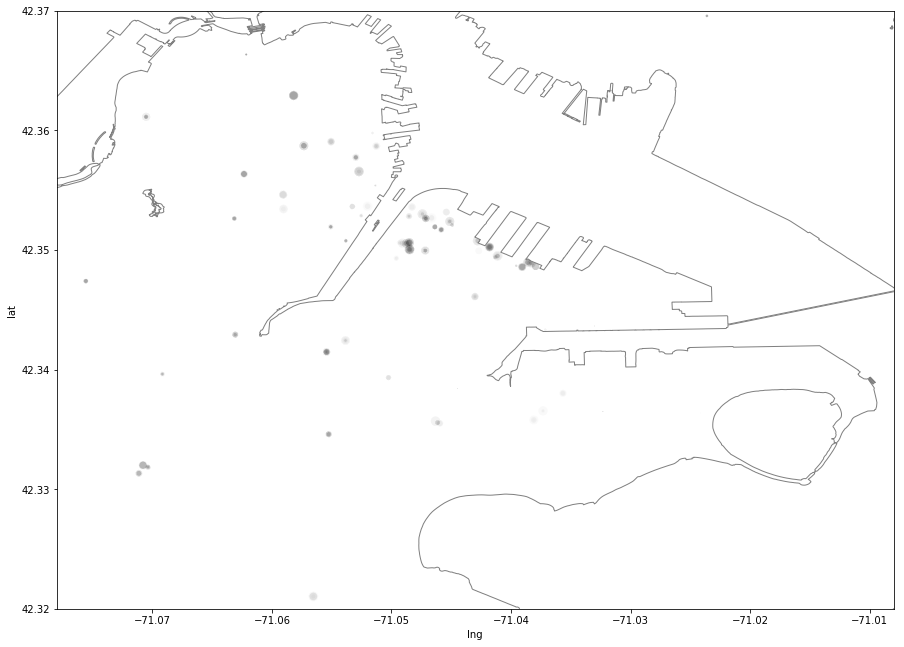

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.figure(figsize=(15,11))
for i in range(24):
    
    ax = sns.scatterplot(x='lng', y='lat', 
                         data=df_records[df_records["hour"]==i],
                         s=df_records[df_records["hour"]==i]["count"],
                         alpha=0.01,
                         color='#000000')
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax = shapefile.plot(ax=ax,alpha=1.0,edgecolor='grey',facecolor='white')
    '''plt.savefig("../data_archives/plot_exports/hour_{}.jpg".format(i), dpi=300, facecolor='w', edgecolor='w',
            papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None)'''
    plt.clf
    plt.close
    if i < 23:
        plt.cla()

## plot kde

In [168]:
#prepare data
X = []
y = []

for i in range(len(df)):
    lat = df.iloc[i]['lat']
    lng = df.iloc[i]['long']
    count = df.iloc[i]['WeekTotals']
    if count > 0:
        for j in range(count):
            X.append(lat)
            y.append(lng)

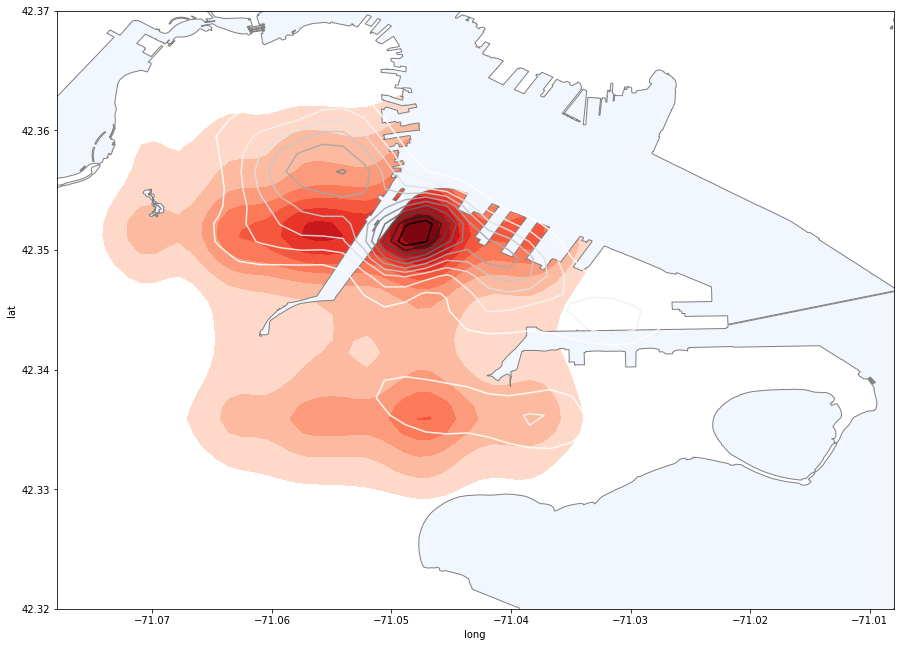

In [169]:
#plot kde
import numpy as np

sample_size=10000

X_sample = np.random.choice(X,size=sample_size,replace=False)
y_sample = np.random.choice(y,size=sample_size,replace=False)

f, ax = plt.subplots(1, figsize=(15, 11))

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

ax = sns.kdeplot(y_sample, X_sample, shade=True,cmap="Reds",shade_lowest=False)
ax = sns.kdeplot(df['long'], df['lat'],shade=False,alpha=0.9,shade_lowest=False,cmap="Greys")
ax = shapefile.plot(ax=ax,alpha=1,edgecolor='grey',facecolor='#f2f7ff')


plt.savefig("../data_archives/plot_exports/kde/sample_{}.jpg".format(sample_size), dpi=300, edgecolor='w',
            papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None)

plt.show()

## box and whiser for each venue type

In [11]:
'''#preprocess and prepare data
from keras.preprocessing.text import text_to_word_sequence
words = []
for i in range(len(df)):
    a = text_to_word_sequence(df.iloc[i]['venue_type'], 
                              filters='!"#$%&()*+,-./:;<=>?@[\]^`{|}~', 
                              lower=False, 
                              split=' ')
    df.at[i,'venue_type'] = a
    for word in a:
        if word not in words:
            words.append(word)
#words'''

Using TensorFlow backend.


In [12]:
type_maps = {'finance':['accounting','finance','atm','bank'],
             'retail':['store','clothing_store','jewelry_store','electronics_store','shoe_store','book_store','home_goods_store','furniture_store','hardware_store','pet_store','department_store','shopping_mall'],
             'transportation':['airport','bus_station','transit_station','gas_station','parking','car_rental','train_station','subway_station','light_rail_station'],
             'food':['cafe','bakery','meal_takeaway','restaurant','food','convenience_store','meal_delivery'],
             'bar':['bar','night_club','liquor_store'],
             'grocery':['grocery_or_supermarket','supermarket'],
             'health_wellness':['health','beauty_salon','hair_care','spa','gym','dentist','doctor','hospital','pharmacy','physiotherapist'],
             'automotive':['car_repair'],
             'professional_services':['lawyer','insurance_agency','general_contractor','travel_agency','real_estate_agency','veterinary_care'],
             'culture_entertainment':['art_gallery','library','museum','movie_theater','park','natural_feature','bowling_alley'],
             'religous':['church','place_of_worship','mosque','synagogue'],
             'government':['courthouse','local_government_office','fire_station','police','post_office'],
             'education':['school','university'],
             'lodging':['lodging'],
             'other':['point_of_interest','establishment','moving_company','storage','premise','bicycle_store','florist','cemetery','laundry','painter','locksmith','plumber','roofing_contractor','car_dealer','car_wash','electrician']}

In [13]:
venue_x = []
count_y = []
for i in range(len(df)):
    vals_to_map = df.iloc[i]['venue_type']    
    for item in vals_to_map:
        item = item[1:-1]
        for key in list(type_maps.keys()):            
            list_to_check = type_maps[key]            
            if item in list_to_check:
                venue_x.append(key)
                count_y.append(df.iloc[i]['WeekTotals'])
df_processed = pd.DataFrame({'type':venue_x,'count':count_y})
df_processed.head()

,count,type
0,0,finance
1,0,finance
2,0,other
3,0,other
4,0,finance


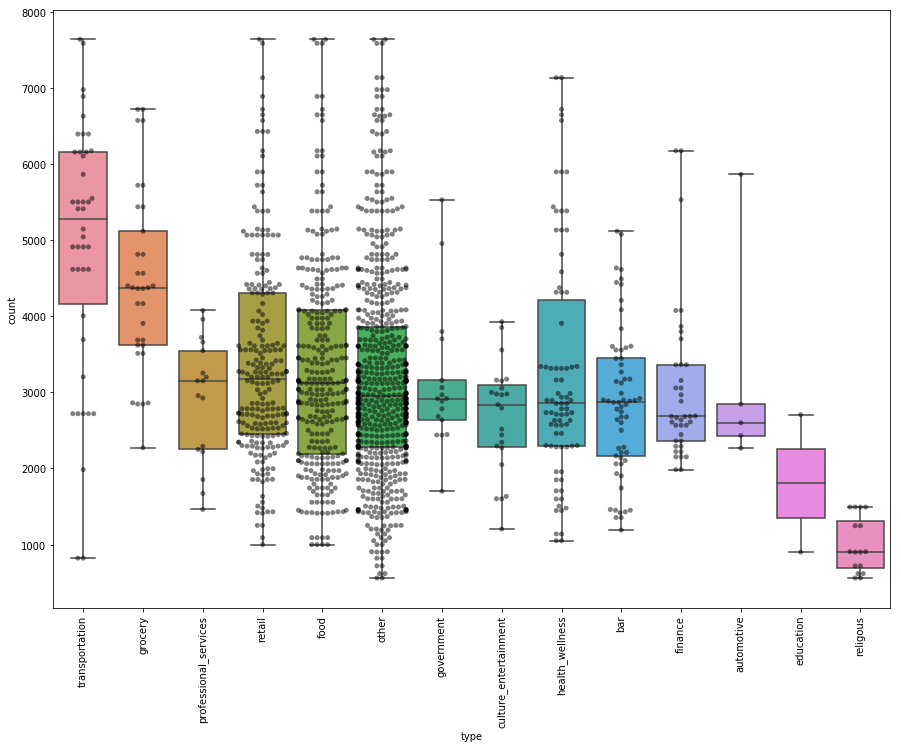

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

sample_data = df_processed[df_processed['count']>0] #.sample(2000)
order = ["transportation", "grocery", "professional_services",
         "retail","food","other","government","culture_entertainment",
         "health_wellness","bar","finance",
         "automotive","education","religous"]

f, ax = plt.subplots(1, figsize=(15, 11))
ax = sns.boxplot(x="type", y="count", data=sample_data,whis=np.inf,order = order)
ax = sns.swarmplot(x="type", y="count", data=sample_data, color='black',alpha=0.5,order=order)
plt.xticks(rotation=90)

plt.savefig("../data_archives/plot_exports/box_swarm/box_swarm1.jpg", dpi=300, edgecolor='w',
            papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None)

In [247]:
df.head()

,name,lat,long,google_id,venue_type,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,WeekTotals
0,Ellis PC,42.348034,-71.041187,ChIJq6qaXoJ644kRoNxCzt2rYyw,"['accounting', 'finance', 'point_of_interest',...",0,0,0,0,0,0,0,0
1,"WithumSmith+Brown, PC",42.349607,-71.042722,ChIJydm7oHhw44kRYeJauZOvntA,"['accounting', 'finance', 'point_of_interest',...",0,0,0,0,0,0,0,0
2,Cantor Stefanie D,42.349819,-71.042828,ChIJ0VvNp3hw44kRxv4C86Zgsi8,"['lawyer', 'accounting', 'finance', 'point_of_...",0,0,0,0,0,0,0,0
3,Goodwin Procter Boston,42.352191,-71.043785,ChIJzyWROoRw44kR__T4RIymGyw,"['accounting', 'lawyer', 'finance', 'point_of_...",690,947,788,1020,630,0,0,4075
4,PwC,42.351162,-71.045188,ChIJ30VlLIJw44kRk4x9eEYUtbg,"['accounting', 'finance', 'point_of_interest',...",525,558,575,644,755,0,0,3057
